# Module 8: Attention and Transformer Architecture

This week we will be working to implement a simple attention based model.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## A Note About Computation

Transformers are some of the most complicated models which we have studied yet - both in terms of the model architecture as well as in terms of the computational power required to train them.
In the real world, transformers are typically require very large training sets with and can be quite expensive to train.

In this class, we won't have access to supercomputing clusters to train our models, so we will have to make due with small examples.
This means that the models we end up creating might not be as performant as we would like.

## Tweets Data

In this lesson we will be using a dataset consisting of tweets.

> **Dataset source:**
> 
>  Bin Tareaf, Raad, 2017, "Tweets Dataset - Top 20 most followed users in Twitter social platform", https://doi.org/10.7910/DVN/JBXKFD, Harvard Dataverse, V2
>
> https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JBXKFD

This dataset consists of 52k tweets by the top 20 most popular users by follower count (as of Nov. 2017)

Tweets make nice data inputs since they are always short!

In [2]:
tweets_data = pd.read_csv('../data/tweets.csv')

# What does this dataset look like?
tweets_data.sample(5)

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
49321,instagram,Celebrating motherhood every day with illustra...,NaN,08/05/2016 17:30,7.293630e+17,en,NaN,NaN,1661,484
14504,YouTube,@IamLeroySanchez Congratulations! 2 million su...,NaN,14/06/2016 22:18,7.428440e+17,en,NaN,NaN,168,66
45431,shakira,"""Los niños más adorables bailando 'La Biciclet...",NaN,11/08/2016 11:38,7.637010e+17,es,NaN,NaN,2119,405
23632,jtimberlake,"Proud this is happening in Franklin, #Tennesse...",NaN,13/09/2016 20:33,7.757940e+17,en,NaN,NaN,1958,394
8685,BarackObama,NASA leads the world in the exploration and st...,NaN,11/05/2015 23:05,5.979000e+17,en,NaN,NaN,1762,997


<Axes: title={'center': 'Tweet Counts'}, xlabel='author'>

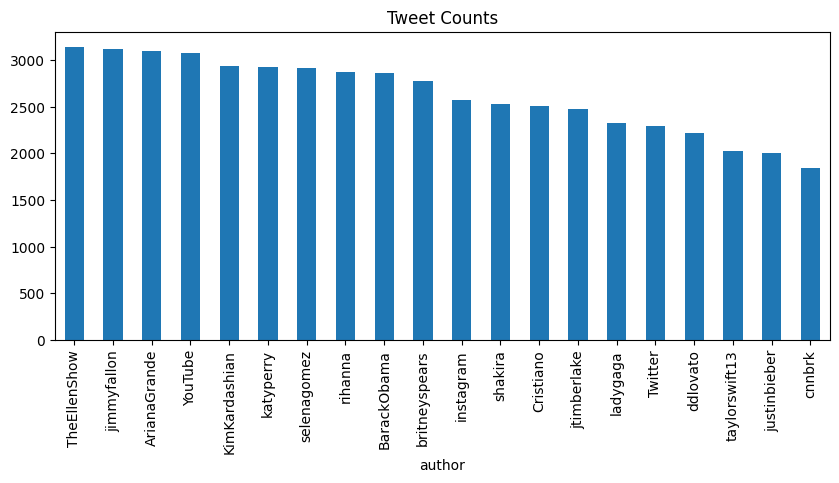

In [3]:
# Who is tweeting?

tweets_data['author'].value_counts().plot(
    kind='bar', figsize=(10, 4), title='Tweet Counts'
)

In [4]:
# Print some tweets:

N_TWEETS_TO_VIEW = 10

for _, row in tweets_data.sample(N_TWEETS_TO_VIEW).iterrows():
    print(f"{row['author']}\n{row['content']}")
    print('\n---\n')

Twitter
Please read the status blog for information if you are missing tweets in your timeline: http://bit.ly/cHJB9w

---

ladygaga
When your up at 5 am because you wanna make sure you don't forget to download @IronMaiden new album The Book of Souls. MUSIC FANDOM IS ALIVE

---

ladygaga
My manager @bobby_campbell made Billboard's #40Under40 Power Players List. I wouldn't be where I am today without him http://t.co/84L7RiX5cg

---

YouTube
I have a trend. 
I have a video. 
UGHN!
Trending Video. 

2016’s most viral → https://t.co/qCf2LeabAo https://t.co/QLebXxA9FG

---

Twitter
@captnchedz Happy birthday, here's another! https://t.co/XWZIuquqVt

---

Cristiano
Hey @Tuurryy impressive play with the @Nikefootball App! These are on their way to you! 😎👍 https://t.co/tXAjIBbTCZ https://t.co/jrYaqKFzlm

---

jtimberlake
Let me know who you all think is your favorite "Not A Bad Love Story"! I want to surprise em! http://t.co/XcpVQvA4z2

---

Cristiano
You asked: Hi Cristiano, can you say me "Ci

Our goal will be to create a model which will attempt to read a tweet and determine who the author is.

## Embedding Layers in Keras

We kick things off today with embedding layers! In the last module, we implemented our example embedding as a simple Python dictionary.
Inside the transformer, we can instead use the [keras embedding layer](https://keras.io/api/layers/core_layers/embedding/).


### Training Embeddings

Embeddings, like any other data structure, need to be trained to be useful.

There are two main ways to train embedding layers:

*  **Standard Training with Backpropagation**
    - An embedding matrix is initialized with random values.
    - During training, backpropagation updates the embeddings based on the loss function.
    - The updates come from the gradient of the loss with respect to the embedding weights.
    - Over time, the embeddings learn to map similar words closer together.
*  **Learning via Word Co-Occurrence (Pretraining)**
    - If two words frequently appear in similar contexts (e.g., “dog” and “puppy”), their embeddings become closer.
    - The model learns embeddings that maximize classification accuracy or some other objective.

For now, we will stick with the standard approach.

### Our Embedding

To keep things simple, we will use the method of encoding each _unique character_.
Normally, you would perfer to encode words, but encoding characters allows us to simplify things for this lesson.

Let's begin by pre-processing the data.

In [5]:
# Create a character-level tokenizer
tokenizer = Tokenizer(char_level=True)  # Tokenize at character level
tokenizer.fit_on_texts(tweets_data['content'])

# Convert text into sequences
sequences = tokenizer.texts_to_sequences(tweets_data['content'])

# Find the maximum sequence length
max_length = max(len(seq) for seq in sequences)

# Pad sequences for uniform input size
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Get vocabulary size (including padding token)
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding index 0

vocab_size

1037

In [6]:
# This contains the encoded tweets
padded_sequences

array([[  7,   6,   1, ...,   0,   0,   0],
       [ 28,  23,   5, ...,   0,   0,   0],
       [ 11,   7,  22, ...,   0,   0,   0],
       ...,
       [ 12,  10,   7, ...,   0,   0,   0],
       [148,  56,   1, ...,   0,   0,   0],
       [ 62,  56, 148, ...,   0,   0,   0]], dtype=int32)

In [7]:
EMBEDDING_SIZE = 12  # Size of embedding vectors

embedding_layer = layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_SIZE,
)

# Look at the embedding output for the first 4 tweets:
emb_output = embedding_layer(padded_sequences[:4]).numpy()

emb_output.shape

(4, 152, 12)

We can see that this embedding layer is outputing a 3D tensor.
Let's make sure we totally understand what we are seeing here:

* Axis 0: The sample axis
* Axis 1: The character axis
* Axis 2: The embedding axis

## Self Attention

In the last lesson, we learned about how the attention calculation worked, using a query, key, and value matrices:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The special case where $Q$, $K$, and $V$ are all the same matrix is called _self attention_.
We do this when we want each token in the input to pay attention to every other token in the input.

## Attention Layer in Keras

Let's get started by now creating the simplist transformer model possible.

Note that the `Attention` layer has _two_ required inputs, so we are not able to use the `Sequential` API here.

In [8]:
# Define input layer
inputs = layers.Input(shape=(max_length,))

# Embedding layer
embedding = layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE)(inputs)

# Self-attention layer (query = value = embedding)
attention = layers.Attention(dropout=.1)([embedding, embedding])

# Perform Layer Normalization for Training Stability
attention_norm = layers.LayerNormalization(epsilon=1e-6)(attention)

# Dense layer
dense = layers.Dense(64, activation="relu")(attention_norm)

# Perform Layer Normalization for Training Stability
dense_norm = layers.LayerNormalization(epsilon=1e-6)(dense)

# Pool across tokens
pooled_output = layers.GlobalAveragePooling1D()(dense_norm)

# Output layer (multi-class classification, 20 classes)
outputs = layers.Dense(20, activation="softmax")(pooled_output)

# Define model
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lowered learning rate for stability
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 152)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 152, 12)   │     12,444 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 152, 12)   │          0 │ embedding_1[0][0… │
│ (Attention)         │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 152, 12)   │         24 │ attention[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 152, 64)   │        832 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 152, 64)   │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      1,300 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,728 (57.53 KB)

 Trainable params: 14,728 (57.53 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Create the target vector
label_names = tweets_data['author'].unique()

# Convert string labels to integer indices
label_mapping = tf.keras.layers.StringLookup(vocabulary=label_names)
y_train = tf.constant(tweets_data['author'])
y_train_encoded = label_mapping(y_train)

# Fix off-by-one errors that the StringLookup creates
y_train_encoded = y_train_encoded - 1

print(y_train_encoded.numpy())  # Output: array of integer indices

[ 0  0  0 ... 19 19 19]


In [10]:
# Check that the model outputs reasonably shapped results before trying to train 
model(padded_sequences[:1])

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0.0325825 , 0.00341011, 0.00589292, 0.0027805 , 0.13329884,
        0.01171823, 0.00196772, 0.01237508, 0.08053779, 0.00950102,
        0.1962702 , 0.0972658 , 0.02377292, 0.33706576, 0.00218757,
        0.00936486, 0.01625931, 0.01866165, 0.00225289, 0.0028344 ]],
      dtype=float32)>

Let's train the model! To simplifying things in this lesson we will only use a training set and not worry about a test set.

In [11]:
model.fit(padded_sequences, y_train_encoded, epochs=20)

Epoch 1/20


I0000 00:00:1739812845.573105     658 service.cc:146] XLA service 0x7f717c0357d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739812845.573138     658 service.cc:154]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
I0000 00:00:1739812845.573143     658 service.cc:154]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5


  99/1642 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0567 - loss: 3.5300

I0000 00:00:1739812848.003864     658 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1642/1642 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1087 - loss: 2.9733
Epoch 2/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2737 - loss: 2.4049
Epoch 3/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3318 - loss: 2.2319
Epoch 4/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3585 - loss: 2.1399
Epoch 5/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3773 - loss: 2.0827
Epoch 6/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3916 - loss: 2.0280
Epoch 7/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4041 - loss: 1.9978
Epoch 8/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4136 - loss: 1.9561
Epoch 9/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4231 - loss: 1.9304
Epoch 10/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4231 - loss: 1.9135
Epoch 11/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4383 - loss: 1.8829
Epoch 12/20
1642/1642 ━━━━━━━━━━━━━━━━━━━

## Improvements

The initial model was able to achieve a training accuracy of around 46%, which all things considered isn't too bad.
Let's now add a few improvements.

### Positional Information with Sinusoidal Positional Encoding

Transformers lack recurrence and convolution, meaning they do not inherently understand the order of tokens in a sequence. Since word order is crucial for understanding meaning (e.g., "The cat chased the dog" vs. "The dog chased the cat"), we need a way to encode position information into the input embeddings.

Positional encodings provide a way to inject sequential information into token embeddings while keeping the model fully differentiable.

#### How Sinusoidal Encoding Works

Instead of learning position embeddings (as in some transformer variations), the original Transformer paper ("Attention is All You Need", Vaswani et al. 2017) used a fixed sinusoidal function. This approach ensures:

* The encoding generalizes to sequences longer than those seen during training.
* The model can learn relative positions rather than absolute positions.

For a given position $pos$ and embedding dimension $i$, the encoding is defined as:

$$PE_{pos,2i} = \sin⁡\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{pos,2i+1} = \cos⁡\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

where:

* $pos$ is the position in the sequence.
* $i$ is the dimension index within the embedding vector.
* $d_{model}$ is the total embedding size
* 10000 is a scaling factor to spread out the values across dimensions.

#### Why Use Sin and Cos Functions?

* Smooth Variation – Nearby positions have similar encodings, allowing the model to interpolate positions smoothly.
* Uniqueness – Each position has a unique encoding due to the combination of sine and cosine functions.
* Relative Positioning – The encoding allows the model to infer relative positions (e.g., "word X is five steps ahead of word Y").

In [12]:
# Here we implement this layer ourselves
# We could also use https://keras.io/keras_hub/api/modeling_layers/sine_position_encoding/
# if we had the keras_hub package installed

class SinePositionalEncoding(layers.Layer):
    """Custom Layer to implement the sinusoidal positional information."""
    
    def __init__(self, sequence_length: int, d_model: int):
        super().__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model
        self.pos_encoding = self._compute_positional_encoding()

    def _compute_positional_encoding(self):
        positions = np.arange(self.sequence_length)[:, np.newaxis]  # Shape: (seq_length, 1)
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-np.log(10000.0) / self.d_model))

        pos_encoding = np.zeros((self.sequence_length, self.d_model))
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        pos_encoding[:, 1::2] = np.cos(positions * div_term)

        return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)  # Shape: (1, seq_length, d_model)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Multihead Attention

Up until now, our model only contains one attention "head".
What this means is that we are only able to calculate one kind of attention relationship for each embedding vector.
However, in real language there are often multiple contexts that need to be taken into account.
Consider

> I do not own a red hat.

Here, the work "hat" should be paying attetion to both the word "red" as an adjective, as well as the word "not" meaning negation.

To achieve this improvement, we replace our `Attention` layers with `MultiHeadAttention` layers.


### Residual Connections

A residual connection (or skip connection) is a technique where the input to a layer is added back to the layer's output. This helps with gradient flow, stabilizing deep networks.


### Batch Normalization

Batch normalization can improve gradient stability and speed up training.

### Add more depth!

The last improvement we can make is to add more total attention layers.
This allows our model to properly learn higher level relationships, at the cost of training computational complexity.
This should be particularly helpful to our model since we are using character-embeddings instead of word-embeddings.

Let's update our model building code and see how things improve!

In [28]:
# Updated model with all the improvements

# Define hyperparameters
EMBEDDING_SIZE = 32 # Embedding layer size
SEQ_LENGTH = 50     # Number of tokens in each input sequence
NUM_HEADS = 4       # Number of attention heads
NUM_LAYERS = 3      # Number of transformer layers
DFF = 128           # Size of feedforward network

# Define input layer
inputs = tf.keras.Input(shape=(max_length,))

# Embedding layer with mask support
embedding = layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE)(inputs)

# Built-in Keras sinusoidal positional encoding
pos_encoding = SinePositionalEncoding(sequence_length=max_length, d_model=EMBEDDING_SIZE)(embedding)

# Transformer Encoder Block
x = pos_encoding

for _ in range(NUM_LAYERS):
    # Multi-Head Attention
    attn_output = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBEDDING_SIZE)(x, x)
    
    # Residual connection and normalization
    x = layers.Add()([x, attn_output])  
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.BatchNormalization()(x)
    
    # Feedforward layer
    ffn = layers.Dense(DFF, activation="relu")(x)
    ffn = layers.Dense(EMBEDDING_SIZE)(ffn)
    
    # Residual connection and normalization
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.BatchNormalization()(x)

# Global pooling
pooled_output = layers.GlobalAveragePooling1D()(x)

# Output layer (20 classes)
outputs = layers.Dense(20, activation="softmax")(pooled_output)

# Define and compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Display model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 152)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 152, 32)   │     33,184 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_positional_en… │ (None, 152, 32)   │          0 │ embedding_11[0][… │
│ (SinePositionalEnc… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 152, 32)   │     16,800 │ sine_positional_… │
│ (MultiHeadAttentio… │                   │            │ sine_positional_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 152, 32)   │          0 │ sine_positional_… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 152, 32)   │         64 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 32)   │        128 │ layer_normalizat… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 152, 128)  │      4,224 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 152, 32)   │      4,128 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 152, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 152, 32)   │         64 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 32)   │        128 │ layer_normalizat… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 152, 32)   │     16,800 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 152, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 152, 32)   │         64 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 32)   │        128 │ layer_normalizat… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 152, 128)  │      4,224 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 152, 32)   │      4,128 │ dense_35[0][0]  

 Total params: 110,452 (431.45 KB)

 Trainable params: 110,068 (429.95 KB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
# Requires more training epochs for a more complicated model

model.fit(padded_sequences, y_train_encoded, epochs=50)

Epoch 1/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.1268 - loss: 2.8301
Epoch 2/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2841 - loss: 2.3794
Epoch 3/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3613 - loss: 2.1248
Epoch 4/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4046 - loss: 1.9853
Epoch 5/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4364 - loss: 1.8826
Epoch 6/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4516 - loss: 1.8224
Epoch 7/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4717 - loss: 1.7638
Epoch 8/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4810 - loss: 1.7239
Epoch 9/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4916 - loss: 1.6868
Epoch 10/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4941 - loss: 1.6644
Epoch 11/50
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5110 - loss: 1.6226
Epoch 12/50
1642/1

# Homework

1. Why would we need positional encoding layers in a transformer model?
2. Using the trainined model, write a function which takes the text of a tweet and output's the tweet's author.
3. Update the transformer model from class to predict a tweet's number of likes instead of the author.
4. Transformers, unlike previous models, require a lot more numerical stabalization techniques. Choose one of the methods we used today (layer normalization, batch normalization, residual connections). For the technique that you choose, do some independent research and try to learn what that technique is trying to do. Explain what you discovered.